# Laboratorium 1
#### Bartosz Hanc
1. Zaimplementuj w Pythonie algorytmy wyszukiwania wzorców: naiwny, automat skończony, algorytm KMP.

* Algorytm naiwny $O((n-m)m)$

In [3]:
def naive_string_matching(text, pattern):
    res = []
    for s in range(len(text) - len(pattern) + 1):
        if pattern == text[s:s+len(pattern)]:
            res.append(s)

    return res


* Automat skończony $O(m^3|\Sigma| + n)$

In [4]:
def transition_table(pattern, alphabet):
    result = []
    for q in range(len(pattern) + 1):
        result.append({})

        for a in alphabet:
            k = min(len(pattern) + 1, q + 2)

            while True:
                k = k - 1
                if k == 0 or pattern[:k] == (pattern[:q] + a)[-k:]:
                    break

            result[q][a] = k

    return result

def fa_string_matching(text, delta):
    res, q = [], 0
    length = len(delta) - 1
    for i in range(len(text)):
        q = delta[q][text[i]]
        if q == length:
            res.append(i+1-q)

    return res


* Algorytm KMP $O(m+n)$

In [5]:
def prefix_function(pattern):
    pi, k = [0], 0
    for q in range(1, len(pattern)):
        while k > 0 and pattern[k] != pattern[q]:
            k = pi[k-1]
        if pattern[k] == pattern[q]:
            k += 1
        pi.append(k)

    return pi


def kmp_string_matching(text, pattern, pi):
    #pi = prefix_function(pattern)
    res, q = [], 0

    for i in range(len(text)):
        while q > 0 and pattern[q] != text[i]:
            q = pi[q-1]

        if pattern[q] == text[i]:
            q += 1
        if q == len(pattern):
            res.append(i+1-q)
            q = pi[q-1]
    
    return res


#### Testy porównujące szybkość działania algorytmów
2. Zaimplementuj testy porównujące szybkość działania wyżej wymienionych algorytmów, z rozbiciem na
czas pre-processingu oraz czas wyszukiwania wzorca w tekście (1p).

In [185]:
import timeit
import matplotlib.pyplot as plt


def runtests(text, pattern, alphabet, repeat):
    """
    Print tables and graph showing efficiency comparison between implemented pattern matching
    algorithms as well as their results.
    """

    def measure(stmt): return timeit.repeat(stmt, number=1, repeat=repeat)

    def stats(times): return (min(times), max(times), sum(times)/len(times))

    def print_table(data, title):

        print("-" * 44 + "\n" + title + "\n" + "-" * 44)
        print("{:<8} {:<12} {:<12} {:<12}".format(
            "", "MIN [s]", "MAX [s]", "AVG [s]"))

        for k, v in data.items():
            MIN, MAX, AVG = v
            MIN, MAX, AVG = "{:.3e}".format(
                MIN), "{:.3e}".format(MAX), "{:.3e}".format(AVG)

            print("{:<8} {:<12} {:<12} {:<12}".format(k, MIN, MAX, AVG))

        print("-" * 44)

    PREPROCESS_TIME = {"naive": None, "fa": None, "kmp": None}
    MATCHING_TIME = {"naive": None, "fa": None, "kmp": None}

    # Naive algorithm tests
    ts_prep_naive = [0]
    ts_match_naive = measure(lambda: naive_string_matching(text, pattern))

    PREPROCESS_TIME["naive"] = stats(ts_prep_naive)
    MATCHING_TIME["naive"] = stats(ts_match_naive)

    # FA algorithm tests
    delta = transition_table(pattern, alphabet)
    ts_prep_fa = measure(lambda: transition_table(pattern, alphabet))
    ts_match_fa = measure(lambda: fa_string_matching(text, delta))

    PREPROCESS_TIME["fa"] = stats(ts_prep_fa)
    MATCHING_TIME["fa"] = stats(ts_match_fa)

    # KMP algorithm tests
    pi = prefix_function(pattern)
    ts_prep_kmp = measure(lambda: prefix_function(pattern))
    ts_match_kmp = measure(lambda: kmp_string_matching(text, pattern, pi))

    PREPROCESS_TIME["kmp"] = stats(ts_prep_kmp)
    MATCHING_TIME["kmp"] = stats(ts_match_kmp)

    # Print results

    res_naive = naive_string_matching(text, pattern)
    res_fa = fa_string_matching(text, delta)
    res_kmp = kmp_string_matching(text, pattern, pi)

    print("-" * 44 +
          "\n# of matched patterns\n" +
          "-" * 44 +
          "\nnaive   {}".format(len(res_naive)) + "   {}".format(res_naive[:3]+["..."]) +
          "\nfa      {}".format(len(res_fa)) + "   {}".format(res_fa[:3]+["..."]) +
          "\nkmp     {}".format(len(res_kmp)) + "   {}".format(res_kmp[:3]+["..."]) + "\n" +
          "-" * 44
          )

    print_table(PREPROCESS_TIME,
                title="Preprocessing time ({} repetitions)".format(repeat))
    print_table(MATCHING_TIME,
                title="Matching time ({} repetitions)".format(repeat))

    # Graph config

    fig, ax1 = plt.subplots()
    ax1.set_title("Algorithms efficiency comparison")

    ax1.set_ylabel("Time of preprocessing [s]")
    ax1.errorbar(["naive", "fa", "kmp"],
                 [PREPROCESS_TIME[algo][2] for algo in ("naive", "fa", "kmp")],
                 yerr=[[PREPROCESS_TIME[algo][2]-PREPROCESS_TIME[algo][0] 
                        for algo in ("naive", "fa", "kmp")],
                       [PREPROCESS_TIME[algo][1]-PREPROCESS_TIME[algo][2]
                        for algo in ("naive", "fa", "kmp")]
                       ],
                 fmt="o",
                 capsize=10,
                 color="black")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Time of matching [s]", color="red")
    ax2.errorbar(["naive", "fa", "kmp"],
                 [MATCHING_TIME[algo][2] for algo in ("naive", "fa", "kmp")],
                 yerr=[[MATCHING_TIME[algo][2]-MATCHING_TIME[algo][0] 
                        for algo in ("naive", "fa", "kmp")],
                       [MATCHING_TIME[algo][1]-MATCHING_TIME[algo][2]
                        for algo in ("naive", "fa", "kmp")]
                       ],
                 fmt="o",
                 capsize=10,
                 color="red")
    ax2.tick_params(axis='y', labelcolor="red")

    fig.show()


3. Znajdź wszystkie wystąpienia wzorców "pan" oraz "pani" w załączonym pliku, za pomocą każdego
   algorytmu. W raporcie zamieść liczbę dopasowań każdego ze wzorców osobno dla każdego algorytmu.
   Upewnij się, że każdy algorytm zwraca taką samą liczbę dopasowań (1p).

4. Porównaj szybkość działania algorytmów dla problemu z p. 3, z uwzględnieniem czasu
   pre-processingu oraz czasu dopasowania. Pomiar czasu powinien być przeprowadzony co najmniej
   5-krotnie i przedstawione w formie tabeli oraz wykresu, uwzględniającego czas minimalny,
   maksymalny oraz średni czas (1p).

In [181]:
with open("pan-tadeusz.txt", "r", encoding="utf8") as file:
    text = file.read()
alphabet = set(text)


--------------------------------------------
# of matched patterns
--------------------------------------------
naive   100   [129, 1254, 7995, '...']
fa      100   [129, 1254, 7995, '...']
kmp     100   [129, 1254, 7995, '...']
--------------------------------------------
--------------------------------------------
Preprocessing time (10 repetitions)
--------------------------------------------
         MIN [s]      MAX [s]      AVG [s]     
naive    0.000e+00    0.000e+00    0.000e+00   
fa       4.337e-04    6.809e-04    5.045e-04   
kmp      6.000e-07    2.400e-06    9.500e-07   
--------------------------------------------
--------------------------------------------
Matching time (10 repetitions)
--------------------------------------------
         MIN [s]      MAX [s]      AVG [s]     
naive    6.148e-02    6.455e-02    6.302e-02   
fa       3.222e-02    3.486e-02    3.325e-02   
kmp      4.445e-02    5.199e-02    4.709e-02   
--------------------------------------------


C:\Users\barto\AppData\Local\Temp\ipykernel_17192\1825235804.py:107: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


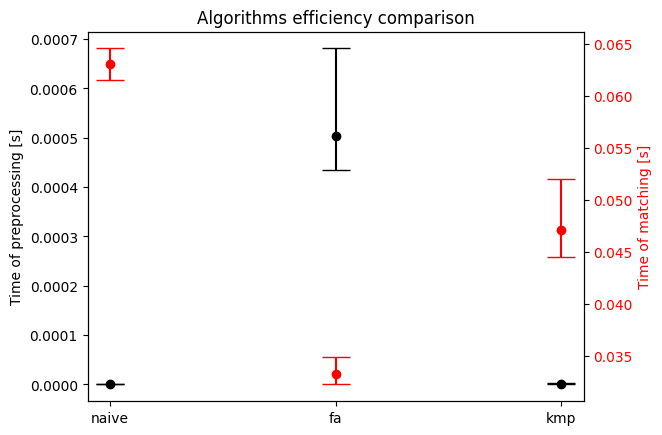

In [205]:
runtests(text=text, pattern="pani", alphabet=alphabet, repeat=10)

--------------------------------------------
# of matched patterns
--------------------------------------------
naive   401   [129, 1254, 2227, '...']
fa      401   [129, 1254, 2227, '...']
kmp     401   [129, 1254, 2227, '...']
--------------------------------------------
--------------------------------------------
Preprocessing time (10 repetitions)
--------------------------------------------
         MIN [s]      MAX [s]      AVG [s]     
naive    0.000e+00    0.000e+00    0.000e+00   
fa       2.763e-04    4.074e-04    3.251e-04   
kmp      6.000e-07    2.500e-06    9.900e-07   
--------------------------------------------
--------------------------------------------
Matching time (10 repetitions)
--------------------------------------------
         MIN [s]      MAX [s]      AVG [s]     
naive    5.955e-02    7.608e-02    6.366e-02   
fa       3.018e-02    4.030e-02    3.290e-02   
kmp      4.319e-02    5.055e-02    4.449e-02   
--------------------------------------------


C:\Users\barto\AppData\Local\Temp\ipykernel_17192\1825235804.py:107: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


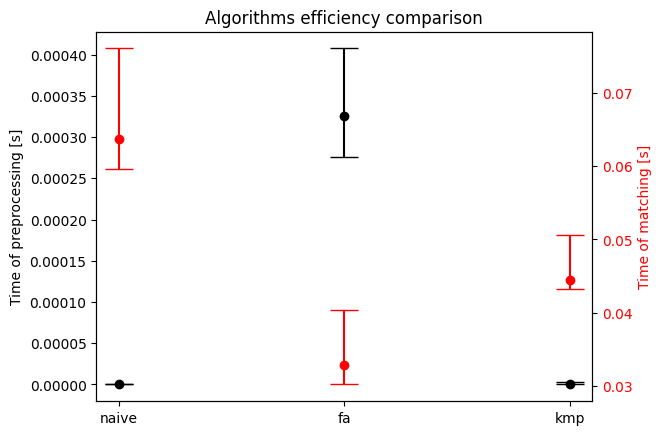

In [208]:
runtests(text=text, pattern="pan", alphabet=alphabet, repeat=10)


5. Zaproponuj tekst oraz wzorzec, dla którego zmierzony czas działania algorytmów 2 oraz 3
   (uwzględniający tylko dopasowanie, bez pre-processingu) będzie co najmniej 5-krotnie krótszy niż
   dla algorytmu naiwnego. Uruchom każdy algorytm na zadanym wzorcu i tekście, w celu sprawdzenia,
   czy zmierzony czas jest faktycznie co najmniej 5-krotnie krótszy (1p).

Ponieważ złożoność algorytmu naiwnego to $O((n-m)m)$, a złożoność fragmentów dopasowujących
`pattern` bez pre-processingu dla algorytmów FA i KMP to $O(n)$, więc wyraźne przyspieszenie można
uzyskać, wybierając `pattern` o długości rzędu $\frac{n}{2}$ dla odpowiednio dużego $n$. Przykładowo
poniżej zaproponowano tekst składający się tylko z jednego znaku `text = "a" * 10**5` i wzorzec
`pattern = "a" * 5 * 10**4`. Dla takich danych wejściowych czasy działania algorytmów FA i KMP bez
pre-processingu są średnio 10 razy mniejsze od czasu działania algorytmu naiwnego.

--------------------------------------------
# of matched patterns
--------------------------------------------
naive   50001   [0, 1, 2, '...']
fa      50001   [0, 1, 2, '...']
kmp     50001   [0, 1, 2, '...']
--------------------------------------------
--------------------------------------------
Preprocessing time (5 repetitions)
--------------------------------------------
         MIN [s]      MAX [s]      AVG [s]     
naive    0.000e+00    0.000e+00    0.000e+00   
fa       2.494e-01    3.080e-01    2.664e-01   
kmp      7.517e-03    8.720e-03    8.017e-03   
--------------------------------------------
--------------------------------------------
Matching time (5 repetitions)
--------------------------------------------
         MIN [s]      MAX [s]      AVG [s]     
naive    2.054e-01    2.316e-01    2.173e-01   
fa       1.117e-02    1.261e-02    1.201e-02   
kmp      2.062e-02    2.363e-02    2.166e-02   
--------------------------------------------


C:\Users\barto\AppData\Local\Temp\ipykernel_17192\1825235804.py:107: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


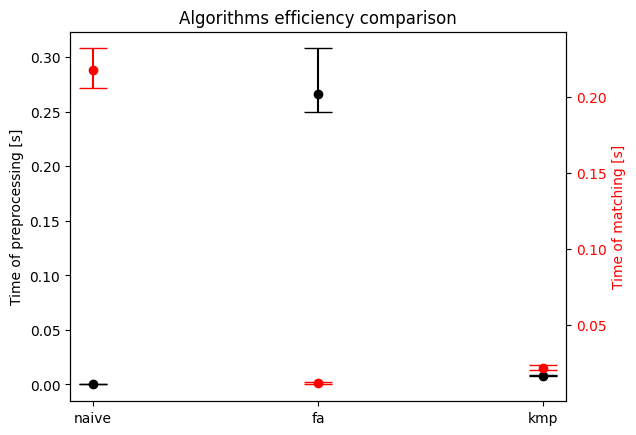

In [197]:
runtests(text="a"*10**5, pattern="a"*5*10**4, alphabet={"a"}, repeat=5)

6. Przedstaw wnioski wynikające z przeprowadzonych eksperymentów, ze szczególnym uwzględnieniem
   praktycznych konsekwencji wynikających z różnic pomiędzy zaimplementowanymi algorytmami (1p).